In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

c:\Users\se99a\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [3]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

In [5]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [6]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [66]:
df.sort_values(['date','tic'],ignore_index=True)

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.364523,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,37.747677,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.793045,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.110201,8449400,XLK,0
...,...,...,...,...,...,...,...,...
30208,2023-05-04,147.660004,148.539993,146.929993,147.231598,5430500,XLK,3
30209,2023-05-04,76.739998,76.860001,76.220001,75.931320,11682600,XLP,3
30210,2023-05-04,68.190002,68.860001,67.550003,68.042702,14631100,XLU,3
30211,2023-05-04,132.899994,132.979996,131.839996,131.857208,9625300,XLV,3


In [62]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [44]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [45]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364523,7567500,XLB,0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,25.364523,25.364523,20.040001,0.000000
1,2010-01-04,57.919998,58.810001,57.790001,37.747677,16928400,XLE,0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,37.747677,37.747677,20.040001,0.000000
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,9.344017,9.344017,20.040001,0.000000
3,2010-01-04,28.090000,28.320000,27.959999,21.793045,7471500,XLI,0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,21.793045,21.793045,20.040001,0.000000
4,2010-01-04,23.139999,23.290001,23.100000,19.110201,8449400,XLK,0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,19.110201,19.110201,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30199,2023-05-03,149.690002,150.660004,148.179993,147.940125,5815100,XLK,2,1.101265,151.344400,144.908068,55.182961,46.442993,6.225843,147.699630,143.517544,18.340000,4.220001
30200,2023-05-03,77.059998,77.379997,76.639999,76.119987,11656600,XLP,2,0.875702,77.189108,74.079747,58.998054,93.547472,22.508083,74.795711,73.269686,18.340000,4.220001
30201,2023-05-03,68.639999,69.050003,67.989998,67.526855,11857200,XLU,2,0.319781,69.807814,67.590043,50.161291,8.126302,8.132944,67.692193,66.656867,18.340000,4.220001
30202,2023-05-03,134.259995,134.899994,133.270004,132.912888,8961500,XLV,2,0.915705,134.927106,131.520086,53.906948,54.096702,6.687990,131.318106,129.596837,18.340000,4.220001


In [46]:
processed.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364523,7567500,XLB,0,0.0,25.521519,25.289543,100.0,66.666667,100.0,25.364523,25.364523,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,37.747677,16928400,XLE,0,0.0,25.521519,25.289543,100.0,66.666667,100.0,37.747677,37.747677,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0,0.0,25.521519,25.289543,100.0,66.666667,100.0,9.344017,9.344017,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.793045,7471500,XLI,0,0.0,25.521519,25.289543,100.0,66.666667,100.0,21.793045,21.793045,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.110201,8449400,XLK,0,0.0,25.521519,25.289543,100.0,66.666667,100.0,19.110201,19.110201,20.040001,0.0


In [63]:
list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364523,7567500.0,0.0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,25.364523,25.364523,20.040001,0.000000
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747677,16928400.0,0.0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,37.747677,37.747677,20.040001,0.000000
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,9.344017,9.344017,20.040001,0.000000
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793045,7471500.0,0.0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,21.793045,21.793045,20.040001,0.000000
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110201,8449400.0,0.0,0.000000,25.521519,25.289543,100.000000,66.666667,100.000000,19.110201,19.110201,20.040001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,147.940125,5815100.0,2.0,1.101265,151.344400,144.908068,55.182961,46.442993,6.225843,147.699630,143.517544,18.340000,4.220001
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.119987,11656600.0,2.0,0.875702,77.189108,74.079747,58.998054,93.547472,22.508083,74.795711,73.269686,18.340000,4.220001
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,67.526855,11857200.0,2.0,0.319781,69.807814,67.590043,50.161291,8.126302,8.132944,67.692193,66.656867,18.340000,4.220001
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,132.912888,8961500.0,2.0,0.915705,134.927106,131.520086,53.906948,54.096702,6.687990,131.318106,129.596837,18.340000,4.220001


In [ ]:
#prediction 업로드시 확인 필요부분
prediction_5 = pd.read_csv('prediction_5.csv').set_index('Unnamed: 0')
prediction_10 = pd.read_csv('prediction_10.csv').set_index('Unnamed: 0')
prediction_30 = pd.read_csv('prediction_30.csv').set_index('Unnamed: 0')

In [84]:
#prediction 업로드시 확인 필요부분


prediction_5_list = []
for i in range(len(prediction_5)):
    for j in range(len(tickers)):
        prediction_5_list.append(prediction_5.iloc[i,j])
        
for i in range((len(processed_full)-len(prediction_5_list))//len(tickers)):
    for j in range(len(tickers)):
        prediction_5_list.append(prediction_5.iloc[-1,j])

prediction_10_list = []
for i in range(len(prediction_10)):
    for j in range(len(tickers)):
        prediction_10_list.append(prediction_10.iloc[i,j])

for i in range((len(processed_full)-len(prediction_10_list))//len(tickers)):
    for j in range(len(tickers)):
        prediction_10_list.append(prediction_10.iloc[-1,j])
    
prediction_30_list = []
for i in range(len(prediction_30)):
    for j in range(len(tickers)):
        prediction_30_list.append(prediction_30.iloc[i,j])
for i in range((len(processed_full)-len(prediction_30_list))//len(tickers)):
    for j in range(len(tickers)):
        prediction_30_list.append(prediction_30.iloc[-1,j])
        
print(len(prediction_5_list))

30204


In [85]:
#prediction 업로드시 확인 필요부분

processed_full['prediction_5']=prediction_5_list
processed_full['prediction_10']=prediction_10_list
processed_full['prediction_30']=prediction_30_list

processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction_5,prediction_10,prediction_30
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364523,7567500.0,0.0,0.000000,25.521519,...,100.000000,66.666667,100.000000,25.364523,25.364523,20.040001,0.000000,24.808691,25.736322,28.809017
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747677,16928400.0,0.0,0.000000,25.521519,...,100.000000,66.666667,100.000000,37.747677,37.747677,20.040001,0.000000,43.465008,40.742596,41.320526
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.000000,25.521519,...,100.000000,66.666667,100.000000,9.344017,9.344017,20.040001,0.000000,9.345718,8.834105,10.960411
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793045,7471500.0,0.0,0.000000,25.521519,...,100.000000,66.666667,100.000000,21.793045,21.793045,20.040001,0.000000,25.776966,26.768536,29.518600
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110201,8449400.0,0.0,0.000000,25.521519,...,100.000000,66.666667,100.000000,19.110201,19.110201,20.040001,0.000000,23.978970,25.238838,25.585352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,147.940125,5815100.0,2.0,1.101265,151.344400,...,55.182961,46.442993,6.225843,147.699630,143.517544,18.340000,4.220001,159.986050,199.206280,229.873230
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.119987,11656600.0,2.0,0.875702,77.189108,...,58.998054,93.547472,22.508083,74.795711,73.269686,18.340000,4.220001,77.597080,82.179405,84.626710
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,67.526855,11857200.0,2.0,0.319781,69.807814,...,50.161291,8.126302,8.132944,67.692193,66.656867,18.340000,4.220001,71.436134,72.501410,82.259230
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,132.912888,8961500.0,2.0,0.915705,134.927106,...,53.906948,54.096702,6.687990,131.318106,129.596837,18.340000,4.220001,131.845380,142.892330,185.067350


In [69]:
#prediction 업로드시 확인 필요부분


INDICATORS += ['prediction_5','prediction_10','prediction_30']

In [86]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3591


In [87]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 118


In [88]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 10000,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [89]:
print(buy_cost_list)
num_stock_shares

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [90]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [91]:
agent = DRLAgent(env = env_train)

if_using_a2c = True ##a2c만 사용해보자
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [92]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [93]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

----------------------------------------
| time/                 |              |
|    fps                | 190          |
|    iterations         | 100          |
|    time_elapsed       | 2            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -12.7        |
|    explained_variance | -0.18        |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -24.5        |
|    reward             | 0.0073237848 |
|    std                | 0.992        |
|    value_loss         | 4.8          |
----------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 189      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | -0.395   |
|    learni

In [94]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])


e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [95]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model,
    environment = e_trade_gym)

hit end!


In [96]:
df_account_value_a2c.shape

(399, 2)

In [97]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame(df_result_a2c)

"""result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)"""
result = pd.merge(result, df_dji, left_index=True, right_index=True)


result.columns = ['a2c','dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (400, 8)
Annual return         -0.022145
Cumulative returns    -0.034921
Annual volatility      0.176822
Sharpe ratio          -0.038668
Calmar ratio          -0.100930
Stability              0.215672
Max drawdown          -0.219408
Omega ratio            0.993578
Sortino ratio         -0.053987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003436
Daily value at risk   -0.022305
dtype: float64
result:                       a2c           dji
date                                  
2021-10-01  1.000000e+06  1.000000e+06
2021-10-04  9.837809e+05  9.905746e+05
2021-10-05  9.896655e+05  9.996566e+05
2021-10-06  9.878612e+05  1.002637e+06
2021-10-07  1.000963e+06  1.012483e+06
...                  ...           ...
2023-04-27  1.063093e+06  9.854252e+05
2023-04-28  1.072166e+06  9.933491e+05
2023-05-01  1.077706e+06  9

c:\Users\se99a\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


<Figure size 1500x500 with 0 Axes>

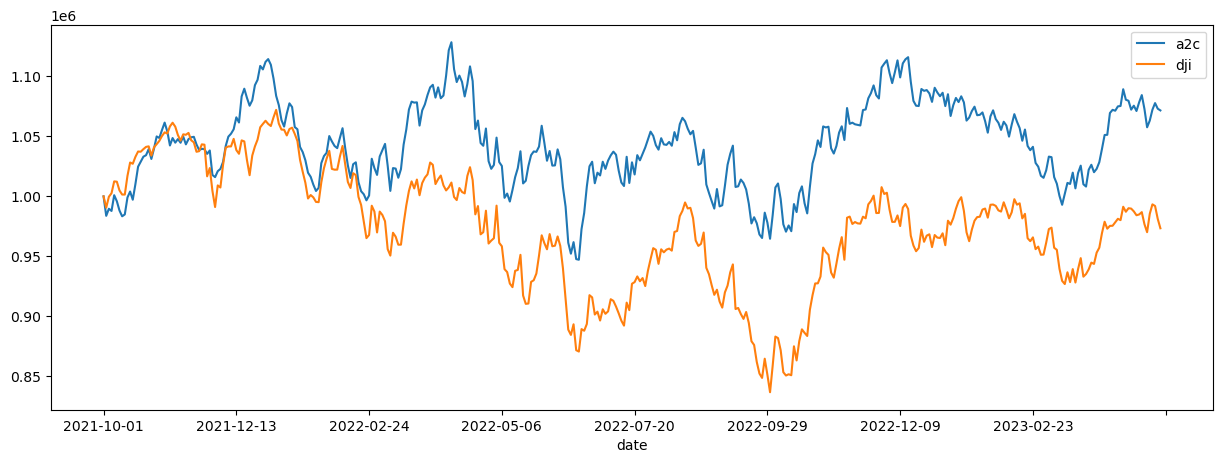

In [98]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [99]:
df_result_a2c.iloc[-1,0] 

1071603.2714578744

In [100]:
print('A2C로 얻은 투자 수익률>>', round((df_result_a2c.iloc[-1,0]/df_result_a2c.iloc[0,0]-1)*100,2),'%')


A2C로 얻은 투자 수익률>> 7.16 %


In [101]:
df_daily_return = df_account_value_a2c
df_daily_return

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.837809e+05
2,2021-10-05,9.896655e+05
3,2021-10-06,9.878612e+05
4,2021-10-07,1.000963e+06
...,...,...
394,2023-04-27,1.063093e+06
395,2023-04-28,1.072166e+06
396,2023-05-01,1.077706e+06
397,2023-05-02,1.073049e+06


In [102]:
df_actions_a2c

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2021-10-01,0,0,1,0,0,0,0,8062,0
2021-10-04,0,0,0,0,0,0,0,0,0
2021-10-05,0,0,0,0,0,0,0,0,0
2021-10-06,0,0,0,0,0,0,0,0,0
2021-10-07,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2023-04-26,0,0,0,0,0,0,0,0,0
2023-04-27,0,0,0,0,0,0,0,0,0
2023-04-28,0,0,0,0,0,0,0,0,0
